In [1]:
# %load_ext tensorboard

In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from timeit import default_timer

from genotype.genotype import RandomArchitectureGenerator

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = nn.Linear(9216, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(128, 10)


     # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        return x


my_nn = Net()
my_nn.to(device)

print(my_nn)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
testset = datasets.MNIST('mnist_test', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)

writer.add_image('images', grid, 0)
writer.add_graph(my_nn, images)
writer.close()

NameError: name 'my_nn' is not defined

In [4]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [trainset.classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [5]:
# helper functions

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, classes):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    fig.tight_layout()
    return fig

In [15]:
num_epochs = 2
writer = SummaryWriter()
running_loss = 0.0
my_nn = Net()
# my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=0.001,)   
criterion = nn.CrossEntropyLoss()

milestones = [k for k in range(0, num_epochs*len(trainloader), 50)]

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.95)

start_t = default_timer()



for epoch in range(num_epochs-1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()

        running_loss += loss.item()
        if i % 10 == 9:    # every 10 batches...
            
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(trainloader) + i)
            writer.add_scalar('Learning rate',
                            optimizer.param_groups[0]['lr'],
                            epoch * len(trainloader) + i)
            

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(my_nn, inputs, labels, trainset.classes),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
#             with torch.no_grad():
#                 for k, data in enumerate(testloader, 0):
#                     inputs, labels = [d.to(device) for d in data]
#                     outputs = my_nn(inputs)
#                     loss = criterion(outputs, labels)
#                     running_loss += loss.item()
#                     if k % 10 == 9:
#                         # ...log the test loss
#                         writer.add_scalar('test loss',
#                                         running_loss,
#                                         epoch * len(testloader) + k)

#                         # ...log a Matplotlib Figure showing the model's predictions on a
#     #                     # random mini-batch
#     #                     writer.add_figure('predictions vs. actuals',
#     #                                     plot_classes_preds(my_nn, inputs, labels, testset.classes),
#     #                                     global_step=epoch * len(testloader) + i)
#                     running_loss = 0.0


end_t = default_timer()
        
print('Finished Training')

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(

KeyboardInterrupt: 

In [5]:
num_epochs = 2
writer = SummaryWriter()
running_loss = 0.0
my_nn = Net()
my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=0.001,)   
criterion = nn.CrossEntropyLoss()

milestones = [k for k in range(0, num_epochs*len(trainloader), 50)]

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.95)

start_t = default_timer()

batch_tt = np.empty(shape=(10,))
k=0
for epoch in range(num_epochs-1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        batch_st = default_timer() 
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = [d.to(device) for d in data]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()

        running_loss += loss.item()
        
        batch_et = default_timer()
        
        batch_tt[k] = batch_et - batch_st
        
        k+=1
        
        if i % 10 == 9:    # every 10 batches...
            
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(trainloader) + i)
            writer.add_scalar('Learning rate',+
                            optimizer.param_groups[0]['lr'],
                            epoch * len(trainloader) + i)
            writer.add_scalar('Average batch time',
                            np.mean(batch_tt).item(),
                            epoch * len(trainloader) + i)
            
            running_loss = 0.0
            batch_tt = np.empty(shape=(10,))
            k=0
        


end_t = default_timer()

total_t = end_t - start_t

writer.add_scalar('Total training time',
                   total_t,
                epoch * len(trainloader) + i)

        
print('Finished Training')

Finished Training


In [95]:
pytorch_total_params = sum(p.numel() for p in my_nn.parameters())
pytorch_total_params

1199882

In [5]:
rag = RandomArchitectureGenerator(prediction_classes=10, min_depth=5, max_depth=7, image_size=28, input_channels=1, min_nodes=5)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [3]:
g, a, network = rag.get_architecture()

Final depth:5
Number of nodes:10


TypeError: 'NoneType' object is not reversible

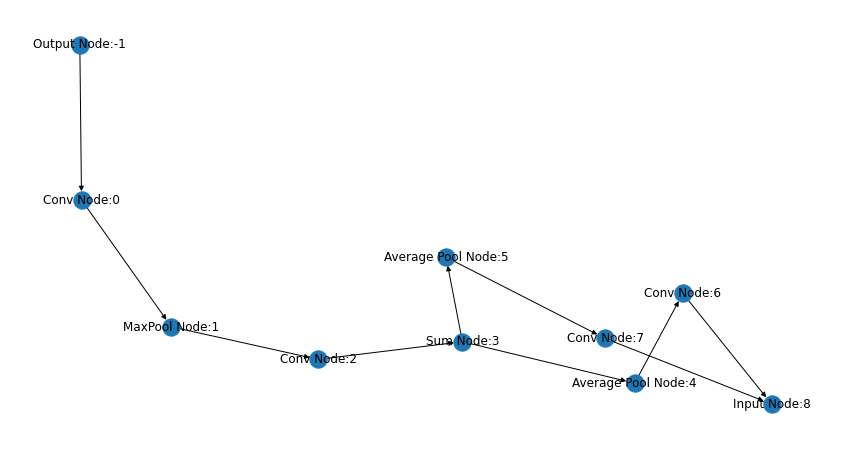

In [21]:
rag.show(g, a, )

In [22]:
rag._module_dict

AttributeError: 'RandomArchitectureGenerator' object has no attribute '_module_dict'

In [8]:
a[3]._parameters

OrderedDict()

In [9]:
list(network.parameters())

[]

In [10]:
num_epochs = 2
writer = SummaryWriter()
running_loss = 0.0
my_nn = network
my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=0.001,)   
criterion = nn.CrossEntropyLoss()

milestones = [k for k in range(0, num_epochs*len(trainloader), 50)]

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.95)

start_t = default_timer()

batch_tt = np.empty(shape=(10,))
k=0
for epoch in range(num_epochs-1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        batch_st = default_timer() 
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = [d.to(device) for d in data]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        scheduler.step()

        running_loss += loss.item()
        
        batch_et = default_timer()
        
        batch_tt[k] = batch_et - batch_st
        
        k+=1
        
        if i % 10 == 9:    # every 10 batches...
            
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(trainloader) + i)
            writer.add_scalar('Learning rate',+
                            optimizer.param_groups[0]['lr'],
                            epoch * len(trainloader) + i)
            writer.add_scalar('Average batch time',
                            np.mean(batch_tt).item(),
                            epoch * len(trainloader) + i)
            
            running_loss = 0.0
            batch_tt = np.empty(shape=(10,))
            k=0
        


end_t = default_timer()

total_t = end_t - start_t

writer.add_scalar('Total training time',
                   total_t,
                epoch * len(trainloader) + i)

        

ValueError: optimizer got an empty parameter list

In [11]:
test_md = nn.ModuleDict()

In [12]:
test_md

ModuleDict()